Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/master/LICENSE.md)


# Running the scanner within a notebook from a definition file

In this notebook we will show how to run a scan from an existing scan template definition

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from sklearn.linear_model import LogisticRegression

from certifai.scanner.builder import CertifaiScanBuilder, CertifaiPredictorWrapper
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.common.utils.encoding import CatEncoder

In [2]:
# Example will use a simple logistic classifier on the German Credit dataset
defs_path = '../definitions'
datasets_path = '../datasets'
scan_def = f"{defs_path}/german_credit_scanner_definition.yaml"
all_data_file = f"{datasets_path}/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)

# Fit a classification model (note - no train/test split here currently as I'm just using the same data as
# the scan will)
model = LogisticRegression(random_state=0, solver="lbfgs", max_iter=1000)
model.fit(encoder(X.values), y)

# Assess on the test set
accuracy = model.score(encoder(X.values), y.values)
print(f"Model accuracy on all data is {accuracy}")

Model accuracy on all data is 0.787


In [3]:
# Wrap the model up for use by Certifai as a local model
model_proxy = CertifaiPredictorWrapper(model, encoder=encoder)


In [4]:
# Run the scan with the local model injected
# First load the scan template
scan = CertifaiScanBuilder.from_file(scan_def)
# Adjust the 'logit' model to use the local predictor
for m in scan.models:
    if m.id == 'logit':
        print("Adding local predictor for logit model")
        m.local_predictor = model_proxy

# For simplicity restrict the output to just the `logit` model (since we only overrode that one) and
# the reports to just the fairness report.  Paths in the scan template are interpreted relative to
# the directory containing the template, but since we're providing a template object directly rather
# than sourcing from the file, we need to provide a `base_path` which relative paths in the template
# will be with respect to.
result = scan.run(model_id='logit',
                  report='fairness',
                  base_path=defs_path)


2020-10-21 17:46:04,986 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)


Adding local predictor for logit model
Starting scan with model_use_case_id: 'c12e/datasciencelab/german_credit' and scan_id: '09007145771c'
[--------------------] 2020-10-21 17:46:04.975926 - 0 of 1 reports (0.0% complete) - Running fairness evaluation for model: logit


2020-10-21 17:46:26,575 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2020-10-21 17:46:35,076 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2020-10-21 17:46:54,087 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2020-10-21 17:47:13,663 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-10-21 17:47:14,566 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples
2020-10-21 17:47:14,567 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 810 samples


[####################] 2020-10-21 17:47:19.579890 - 1 of 1 reports (100.0% complete) - Completed all evaluations


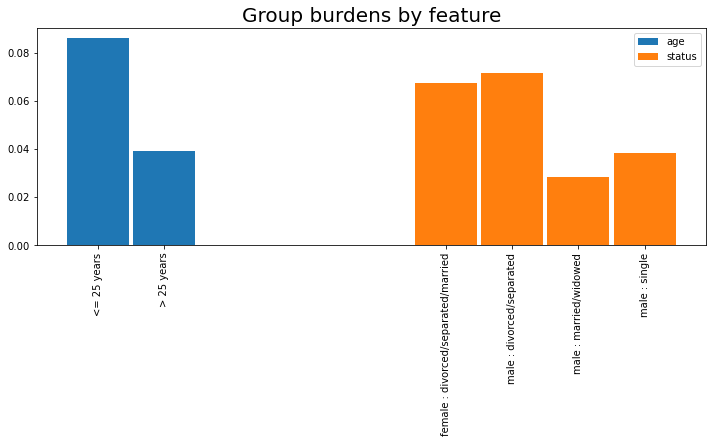

In [5]:
# By default running a scan will write the results into individual report files (one per model and evaluation
# type) in the output directory specified by the template (relative to the `base_path`).  This may be disabled by specifying
# `write_reports=False` in the `run` call above, or forced to a different output directory by specifying
# `output=<override path>`
#
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
#
# Note - saved reports are one model and evaluation type per report file - that is to say that each second level
# entry in the nested dictionary produced by a scan will be saved as a separate file

# We can also take a look at our results in the notebook directly (for example if we want to perform a bespoke analysis
# not directly supported by the console UI)
all_scores = next(scores('fairness', result))

# Plot the burdens for each protected group - first assess the feature and class structure based on the scores
# from a representative sample (the first model)
# Fairness scores have sub-scores for each feature, and within each of those sub-scores for each group
%matplotlib inline
import matplotlib.pyplot as plt

feature_scores = all_scores.children

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Group burdens by feature', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
max_groups = 5
width = 0.75/max_groups
spacing = 0.8/max_groups

ticks = []
ticklabels = []

for f_idx, f in enumerate(feature_scores): 
    feature_group_scores = f.children
    burdens = [b.value for b in feature_group_scores]
    x = [f_idx + g_idx*spacing - ((len(burdens)-1)/2)*spacing for g_idx in range(len(burdens))]
    ticks.extend(x)
    ticklabels.extend([b.name for b in feature_group_scores])
    ax.bar(x,
           burdens,
           width=width,
           color=colors[f_idx],
           label=f.name)

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation='vertical')
ax.legend()
plt.show()

Perfect fairness would imply equality of burdens between groups within each feature (so the heights of all bars
of any given color in the above plot would be equal).  Disparity indicates greater burden for one protected group
over another, and a plot such as the above allows us to see where the greater burden falls.  Looking at age for example, we can see that younger applicants have over twice the burden of older applicants, meaning there is a bias
against youth in the model.  Note that any such analysis is always with respect to the distribution of input data, so
it is possible that this model would not exhibit this bias with a different correlation structure against age.  For this reason it is very important that we always anlayse datasets that are representative of the data on which the model will actually be predicting in deployment.